<a href="https://colab.research.google.com/github/hamagami/anomaly-detection/blob/main/04_06_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# オートエンコーダによる時系列異常検知

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DIR="drive/My Drive/Colab Notebooks/異常検知サンプルコード/"

Mounted at /content/drive


### 必要なモジュールのimport

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.models import Model
#from keras.layers import Dense #, Dropout, Flatten
#from keras.layers.convolutional import Conv1D, UpSampling1D
#from keras.layers.pooling import MaxPooling1D
#from keras.utils import np_utils
#from keras.utils import plot_model
#from sklearn.metrics import accuracy_score
#from sklearn.model_selection import train_test_split
#from sklearn import svm

### セグメントの切り出し関数

In [ ]:
def segdata(lst, dim):
    emb = np.empty((0,dim), float)
    for i in range(lst.size - dim + 1):
        tmp = np.array(lst[i:i+dim])[::-1].reshape((1,-1)) #セグメントの切り出し，時系列反転，appendのための2次ベクトル化
        emb = np.append( emb, tmp, axis=0)
    return emb

### データ読み込み，パラメータ設定
 Keoghらの心電図のデータ  http://www.cs.ucr.edu/~eamonn/discords/qtdbsel102.txt
 Keogh, E., Lin, J. and Fu, A.: HOT SAX : Efficiently Finding the Most Unusual Time Series Subsequence, in Proceedings of the Fifth IEEE International Conference on Data Mining, ICDM 05, pp.226-233.

In [ ]:
LEN=3000  #分析区間
WLEN=100 #セグメントのサイズ
SP=0         #学習用データの開始点
AP=3000   #テスト用データの開始点　個のデータの場合 4250ポイント付近に異常がある

In [ ]:
data = np.loadtxt(DIR+"04/data/qtdbsel102.txt",delimiter="\t")
print("データ数:",data.shape[0],"  次元数:",data.shape[1])

#元データは3次元の時系列，3次のデータ(indexとしては2)を指定して学習/テストデータに分割
train_org = data[SP:SP+LEN, 2]      #学習用データとして 1～2999サンプル区間を使用
test_org  = data[AP:AP+LEN, 2]  #テスト用データとして3000～5999サンプルを使用

データ数: 45000   次元数: 3


### 窓関数の設定と切り出し

In [ ]:
seglen = WLEN   #Window size
#winlenの単位で1ポイントずつずらした2次元表現に変換
x_train = segdata(train_org, seglen)
x_test  = segdata(test_org,seglen)

### AEのデザイン

In [ ]:
input_img = Input(shape=(100,))
encoded = Dense(64, activation='linear')(input_img)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(16, activation='relu',name='middle_code')(encoded)

decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(100, activation='linear',name='output_code')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

### AEの学習

In [ ]:
history=autoencoder.fit(np.array(x_train), np.array(x_train),
                epochs=1000,
                batch_size=50,
                shuffle=True,
                verbose=1,
                validation_split=0.1)
                #validation_data=(np.array(x_valid), np.array(x_valid)))

model_json_str = autoencoder.to_json()
open('ae_model.json', 'w').write(model_json_str)
autoencoder.save_weights('ae_weights.h5');

Epoch 1/1000
53/53 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 0.3904 - val_loss: 0.0038 - val_accuracy: 0.4708
Epoch 2/1000
53/53 [==============================] - 0s 2ms/step - loss: 0.0038 - accuracy: 0.3958 - val_loss: 0.0045 - val_accuracy: 0.4364
Epoch 3/1000
53/53 [==============================] - 0s 2ms/step - loss: 0.0039 - accuracy: 0.4000 - val_loss: 0.0044 - val_accuracy: 0.4192
Epoch 4/1000
53/53 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 0.4027 - val_loss: 0.0038 - val_accuracy: 0.4570
Epoch 5/1000
53/53 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 0.3989 - val_loss: 0.0039 - val_accuracy: 0.4227
Epoch 6/1000
53/53 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 0.4034 - val_loss: 0.0037 - val_accuracy: 0.4192
Epoch 7/1000
53/53 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 0.3943 - val_loss: 0.0038 - val_accuracy: 0.4502
Epoch 

### 学習曲線の表示

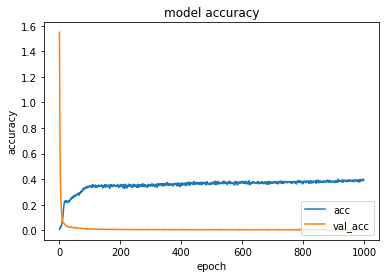

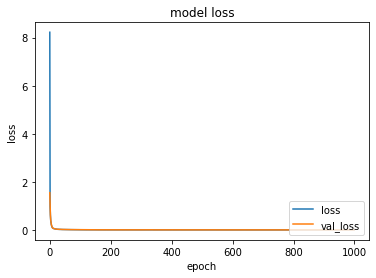

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['acc', 'val_acc'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'], loc='lower right')
plt.show()

### 波形と復元誤差の描画

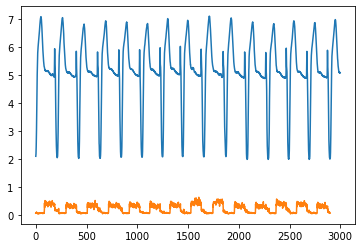

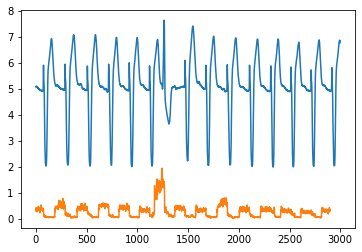

In [ ]:
#encoded_sig = Model(input_img, encoded
decoded_trainsig = autoencoder.predict(x_train)
decoded_testsig = autoencoder.predict(x_test)
trainloss=[]
testloss=[]
for i,d in enumerate(decoded_trainsig):
    #plt.plot(d)
    #plt.show()
    d_trainsig = d-x_train[i]
    d_testsig  = decoded_testsig[i]-x_test[i]
    #print(np.linalg.norm(d_sig,ord=100))
    trainloss.append(np.linalg.norm(d_trainsig, ord=WLEN))
    testloss.append(np.linalg.norm(d_testsig, ord=WLEN))
#print(loss)
plt.plot(train_org)
plt.plot(trainloss)
plt.show()
plt.plot(test_org)
plt.plot(testloss)
plt.show()